In [ ]:
from audIBle.data.datasets import ESC_50

In [ ]:
root = "/lium/corpus/vrac/tmario/"
dataset = ESC_50(root=root, part='train')

In [ ]:
import torch
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
for i, (audio, target) in enumerate(data_loader):
    print(audio.shape)
    print(target.shape)
    break

In [ ]:
from audIBle.data.datasets import UrbanSound8k
import os
import torch
root = "/lium/corpus/vrac/tmario/sed/urbansound8k/urbansound8k/"
dataset = UrbanSound8k(csv_path=os.path.join(root, "metadata/UrbanSound8K.csv"),
                           audio_dir=os.path.join(root, "audio"),
                           sample_rate=22050,
                           folds_to_use=[1,2,3,4,5],
                           duration=4.0,)

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
for i, (audio, target) in enumerate(data_loader):
    print(audio.shape)
    print(target.shape)
    break

In [ ]:
import torch
a = []
for i in range(10):
    a.append(torch.randn((1,)))

a_s = torch.stack(a).mean(dim=0)
print(a_s.shape)



In [ ]:
ll = [1,3,4,7]
print('_'.join(str(i) for i in ll))

In [ ]:
import torch
all_rep = []
for k in range(10):
    y = torch.randn(64,356,768)
    y_pool = y.mean(dim=1)
    all_rep.append(y_pool)

y_st = torch.stack(all_rep, dim=1)
y_ct = torch.cat(all_rep)

print(f"{y_st.shape=}\n{y_ct.shape=}")


In [ ]:
from datasets import load_dataset,Audio
timit = load_dataset("timit_asr", data_dir="/lium/corpus/vrac/tmario/timit/TIMIT")

In [ ]:
# Example usage
from audIBle.data.speech import TimitDataset
data_dir = "/lium/corpus/base/TIMIT"  # Replace with your TIMIT path

# Create datasets
train_dataset = TimitDataset(data_dir, split="train", samplerate=16000, length=0.5)
test_dataset = TimitDataset(data_dir, split="test", samplerate=16000, length=0.5)


In [ ]:

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Get phoneme statistics
train_phonemes = train_dataset.get_phoneme_counts()
print(f"Number of unique phonemes in train: {len(train_phonemes)}")
print("Top 10 most frequent phonemes:")
sorted_phonemes = sorted(train_phonemes.items(), key=lambda x: x[1], reverse=True)
for phoneme, count in sorted_phonemes[:10]:
    print(f"  {phoneme}: {count}")


In [ ]:

# Test a sample
idx=3
audio, label = train_dataset[idx]
print(f"Sample audio shape: {audio.shape}")
print(f"Sample label: {label}")
print(f"Sample phoneme: {train_dataset.phone_segments[idx]['phoneme']}")


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
nr = 4
nc = 4

import torchaudio

spec_transform = torchaudio.transforms.Spectrogram(n_fft=512, win_length=512, hop_length=128, power=2)

fig, axs = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 12))
for ax, idx in zip(axs.flat, np.random.choice(len(train_dataset), size=(nr*nc,), replace=False)):
    audio, label = train_dataset[idx]
    nn = torch.randn_like(audio) * 1e-6
    audio = audio + nn
    # Compute spectrogram using torchaudio transform
    S = spec_transform(audio.float())
    ax.imshow(10 * torch.log10(S).numpy(), aspect='auto', origin='lower', cmap='gray')
    ax.set_title(f"Phoneme: {train_dataset.phone_segments[idx]['phoneme']}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("Frequency bin")
plt.tight_layout()
plt.show()




### Test dataset wrapper

In [ ]:
from audIBle.data.datasets import select_dataset
data_dir = "/lium/corpus/base/TIMIT"
cfg = {"data_dir":data_dir,"split": "train", "subsplit": "train", "samplerate": 16000, "length": 0.5}
dataset = select_dataset(dataset_name="timit", **cfg)

In [ ]:
cfg = {"data_dir":data_dir,"split": "train", "subsplit": "valid", "samplerate": 16000, "length": 0.5}
dataset = select_dataset(dataset_name="timit", **cfg)

In [ ]:
cfg = {"data_dir":data_dir,"split": "test", "samplerate": 16000, "length": 0.5}
dataset = select_dataset(dataset_name="timit", **cfg)

# VocalSet

In [2]:
from audIBle.data.music import VocalSet

In [3]:
sr = 16000
train_set = VocalSet(root="/lium/corpus/vrac/VocalSet/FULL", split="train", seed=42, ratio=0.8,duration=5.0, target_sr=sr)
print(f"{len(train_set)=}")
valid_set = VocalSet(root="/lium/corpus/vrac/VocalSet/FULL", split="valid", seed=42, ratio=0.2,duration=5.0, target_sr=sr)
print(f"{len(valid_set)=}")

len(train_set)=1269
len(valid_set)=1307


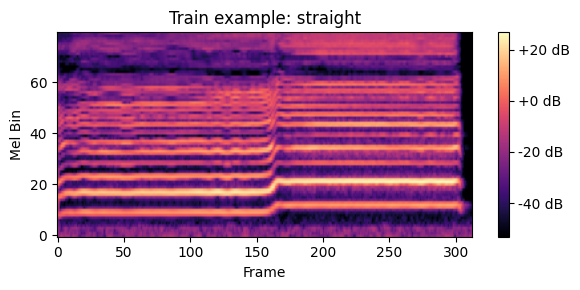

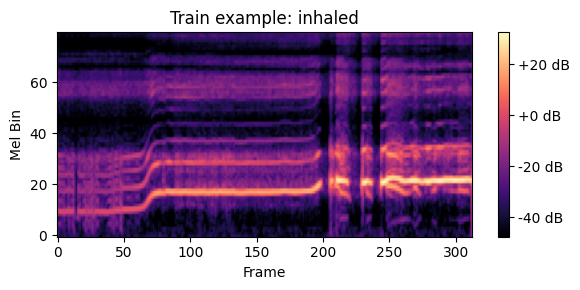

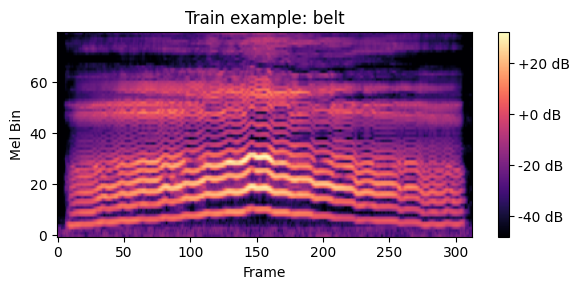

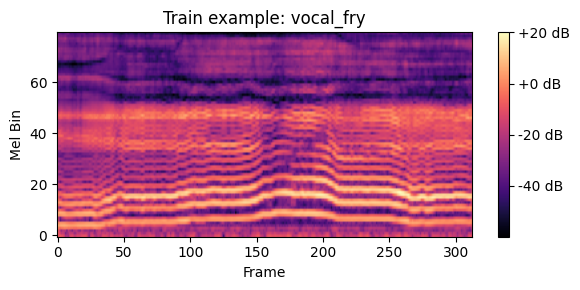

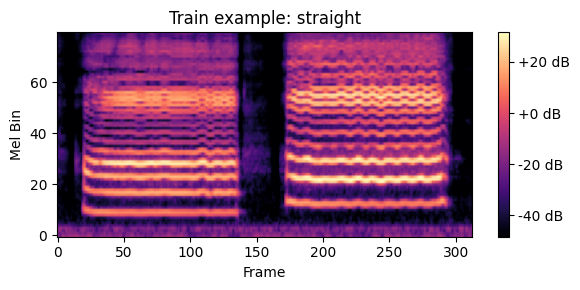

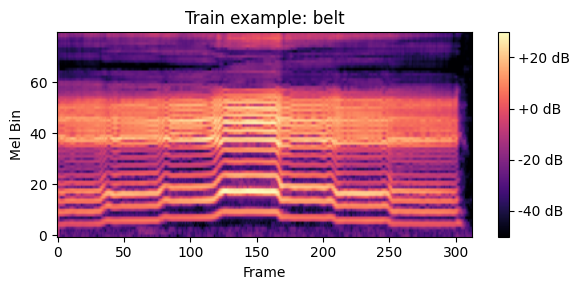

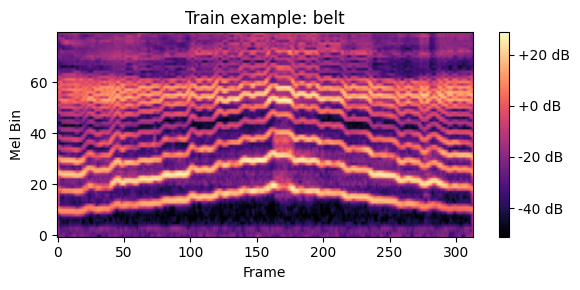

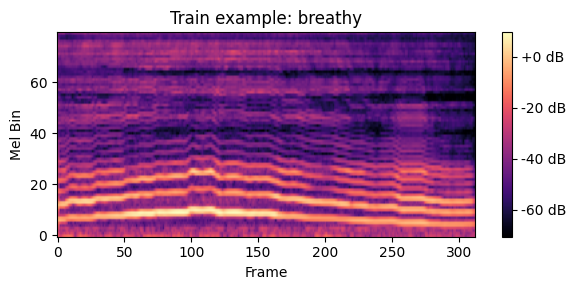

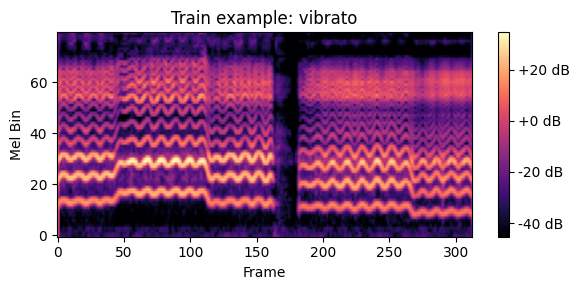

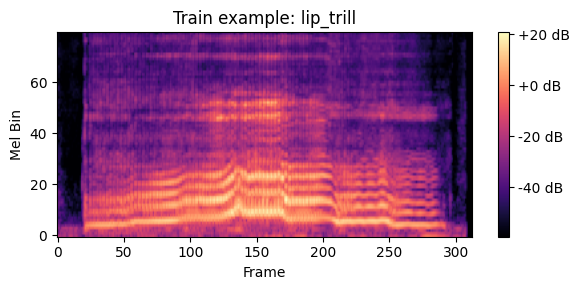

In [5]:
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np


idx_set = np.random.choice(len(train_set),size=(10,),replace=False)

for ii in idx_set:
    audio, label = train_set[ii]

    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        hop_length=256,
        n_mels=80
    )
    
    ipd.display(ipd.Audio(audio, rate=sr))
    
    mel_spec = mel_transform(audio)
    mel_spec_db = torchaudio.functional.amplitude_to_DB(mel_spec, multiplier=10.0, amin=1e-10, db_multiplier=0.0, top_db=80.0)

    plt.figure(figsize=(6, 3))
    plt.imshow(mel_spec_db.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Train example: {train_set.techniques[label.item()]}")
    plt.xlabel("Frame")
    plt.ylabel("Mel Bin")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()



### Dataset cleaning

Steps to create the dataset `VocalSet` available in `audIBle.data.music`

In [6]:
from torch.utils.data import Dataset
import torch
import glob
import os
from pathlib import Path
from typing import Tuple, Union
import random
import torchaudio
import numpy as np
import pandas as pd

class VOCALSET(Dataset):
    def __init__(self, root: Union[str, Path],
                 split: str = None,
                 seed: int = None,
                 ratio: float = None,
                 duration: float = 5.0,
                 target_sr: int = 16000) -> None:
        """
        Russell Izadi 2023
        Théo Mariotte 2025
        """
        list_paths = glob.glob(os.path.join(
            root, '**/*.wav'), recursive=True)

        if split is not None:
            list_paths_train, list_paths_valid = self.random_split(
                list_paths, seed=seed, ratio=ratio)
            if split == 'train':
                list_paths = list_paths_train
            elif split == 'valid':
                list_paths = list_paths_valid

        self.list_paths = list_paths
        self.data = self.get_data(list_paths)
        self.indices = self.get_indices(self.data)
        self.target_sr = target_sr
        # length of the training segment
        self.length = int(target_sr * duration) if duration is not None else None
        self.orig_sr = 44100
        self.resample = torchaudio.transforms.Resample(orig_freq=self.orig_sr, new_freq=self.target_sr)
        self.split = split
        self.techniques = ['belt', 'breathy', 'inhaled', 'lip_trill', 'spoken', 'straight', 'trill', 'trillo', 'vibrato', 'vocal_fry']
        self.techniques_map = {technique: idx for idx, technique in enumerate(self.techniques)}
        

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, int, set, str]:
        if i >= len(self):
            raise IndexError
        
        path_wav = self.data["path"].iloc[i]
        label = self.techniques_map[self.data["techique"].iloc[i]]
        # path_wav, label_full = self.data[i]

        audio, sr = torchaudio.load(path_wav)

        if self.orig_sr != self.target_sr:
            audio = self.resample(audio)

        audio_len = audio.shape[-1]
        
        if self.length is not None:
            if audio_len < self.length:
                pad_len = self.length - audio_len
                audio = torch.nn.functional.pad(audio, (0, pad_len))
            if audio_len > self.length:
                if self.split == "train":
                    start = random.randint(0, audio_len - self.length)
                else:
                    start = 0
                audio = audio[:, start:start + self.length]
        
        

        return audio, torch.Tensor([label]).to(torch.int64)

    def __len__(self):
        return len(self.data)

    @staticmethod
    def get_data(list_path_wavs):

        data = []
        for path in list_path_wavs:
            singer = path.split("/")[-4]
            context = path.split("/")[-3]
            technique = path.split("/")[-2]
            vowel = path.split("/")[-1].split(".")[0].split("_")[-1]

            label = {
                'singer': singer,
                'context': context,
                'technique': technique,
                'vowel': vowel}

            data.append((path, label))
            
        return data
    
    def _preprocess_data(self):
        """
        Method to filter unused audio segments
        """
        # keep only 10 singing techniques as in the original paper
        df = pd.DataFrame([
            {'path': path, **label}
            for path, label in self.data])
        
        # rename vibrado (typo in the labels)
        df.loc[df["technique"] == "vibrado"] = "vibrato"

        # keep only the 10 techniques of interest
        df_tech = df.loc[df['technique'].isin(['belt', 'breathy', 'inhaled', 'lip_trill','spoken', 'straight', 'trill','trillo', 'vibrato', 'vocal_fry'])]

        # keep only the vowels and spoken signals (other vowels represent the uncut audio)
        df_final = df_tech.loc[df_tech["vowel"].isin(['e', 'o', 'i', 'a', 'u', 'c','f','spoken'])]

        self.data = df_final

        

    @staticmethod
    def get_indices(data):

        indices = {}
        for idx, (_, label) in enumerate(data):
            for key, value in label.items():
                if key not in indices:
                    indices[key] = {}
                if value not in indices[key]:
                    indices[key][value] = []
                indices[key][value].append(idx)

        return indices

    @staticmethod
    def random_split(list_, seed=0, ratio=0.8):
        random.seed(seed)
        random.shuffle(list_)
        n_samples = int(len(list_) * ratio)
        return list_[:n_samples], list_[n_samples:]

In [7]:
sr = 16000
train_set = VOCALSET(root="/lium/corpus/vrac/VocalSet/FULL", split="train", seed=42, ratio=0.8,duration=5.0, target_sr=sr)
print(f"{len(train_set)=}")
valid_set = VOCALSET(root="/lium/corpus/vrac/VocalSet/FULL", split="train", seed=42, ratio=0.2,duration=5.0, target_sr=sr)
print(f"{len(valid_set)=}")

len(train_set)=2890
len(valid_set)=722


### Checks for data cleaning (with the original dataset code)

In [8]:
import pandas as pd

df = pd.DataFrame([
    {'path': path, **label}
    for path, label in train_set.data
])
df.head()


path   singer    context  \
0  /lium/corpus/vrac/VocalSet/FULL/female5/arpegg...  female5  arpeggios   
1  /lium/corpus/vrac/VocalSet/FULL/male4/arpeggio...    male4  arpeggios   
2  /lium/corpus/vrac/VocalSet/FULL/male6/scales/s...    male6     scales   
3  /lium/corpus/vrac/VocalSet/FULL/female6/arpegg...  female6  arpeggios   
4  /lium/corpus/vrac/VocalSet/FULL/female4/scales...  female4     scales   

    technique vowel  
0  fast_forte     e  
1  fast_piano     o  
2  slow_forte     i  
3   lip_trill     e  
4        belt     a

In [9]:
#Length of the dataset
len(df)

2890

In [10]:
df_f = df[(df["singer"] == "female2")]
pd.set_option("display.max_rows", None)
df_f

path   singer     context  \
36    /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
48    /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
54    /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
61    /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
80    /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
99    /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
105   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
111   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
134   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
138   /lium/corpus/vrac/VocalSet/FULL/female2/long_t...  female2  long_tones   
171   /lium/corpus/vrac/VocalSet/FULL/female2/excerp...  female2    excerpts   
183   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
208   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
220   /lium/corpus/vrac/VocalSet/FULL/female2/long_t...  female2  long_tones   
306   /lium/corpus/vrac/VocalSet/FULL/female2/long_t...  female2  long_tones   
317   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
318   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
342   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
379   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
381   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
398   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
416   /lium/corpus/vrac/VocalSet/FULL/female2/long_t...  female2  long_tones   
433   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
441   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
446   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
457   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
479   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
510   /lium/corpus/vrac/VocalSet/FULL/female2/long_t...  female2  long_tones   
576   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
581   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
609   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
620   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
636   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
646   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
658   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
664   /lium/corpus/vrac/VocalSet/FULL/female2/excerp...  female2    excerpts   
669   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
675   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
684   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
687   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
731   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
744   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
849   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
858   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
910   /lium/corpus/vrac/VocalSet/FULL/female2/excerp...  female2    excerpts   
924   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
928   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
939   /lium/corpus/vrac/VocalSet/FULL/female2/arpegg...  female2   arpeggios   
952   /lium/corpus/vrac/VocalSet/FULL/female2/scales...  female2      scales   
956   /lium/corpus/vrac/VocalSet/FULL/female2/scale

In [11]:
df.loc[df["technique"] == "vibrado"] = "vibrato"
df_filt = df.loc[df['technique'].isin(['belt', 'breathy', 'inhaled', 'lip_trill','spoken', 'straight', 'trill','trillo', 'vibrato', 'vocal_fry'])]
df_final = df_filt.loc[df_filt["vowel"].isin(['e', 'o', 'i', 'a', 'u', 'c','f','spoken'])]

pd.set_option("display.max_rows", 20)

print(df_final["technique"].unique())
print(df_final["vowel"].unique())

df_final

print(f"Length original {len(df)=}")
print(f"Length clean {len(df_final)=}")

['lip_trill' 'belt' 'straight' 'inhaled' 'breathy' 'vocal_fry' 'vibrato'
 'spoken' 'trill' 'trillo']
['e' 'a' 'i' 'u' 'o' 'spoken']
Length original len(df)=2890
Length clean len(df_final)=1269


In [12]:
df_ = df[df["vowel"]=="u(1)"]
print(len(df_))
for i in range(len(df_)):
    audio, sr = torchaudio.load(df_["path"].iloc[i])
    print(df_.iloc[i])
    ipd.display(ipd.Audio(audio, rate=sr))
    if i > 4:
        break
    

2
path         /lium/corpus/vrac/VocalSet/FULL/female2/scales...
singer                                                 female2
context                                                 scales
technique                                             straight
vowel                                                     u(1)
Name: 609, dtype: object


path         /lium/corpus/vrac/VocalSet/FULL/female2/scales...
singer                                                 female2
context                                                 scales
technique                                           slow_piano
vowel                                                     u(1)
Name: 1904, dtype: object


In [13]:
print(df["vowel"].unique())

['e' 'o' 'i' 'a' 'u' 'spoken' 'straight' 'vibrato' 'c' 'piano' 'u(1)' 'f'
 'a(1)' 'trill' 'arps']
